# EOF analysis of surface freshwater content & analysis of modes

This notebook includes the work of EOF decomposition on surface freshwater content (FWC), the analysis and explainations of each modes.

* EOF(FWC) --> different modes
* Different modes affect by different atmos. patterns
* The role of freshwater components in each modes 

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [724]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [3]:
sb.set_style('white')
#sb.set_style("whitegrid")

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#from IPython.utils.path import get_ipython_dir
#print get_ipython_dir()

In [4]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [5]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [6]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

# Method & data

## Surface freshwater content (FWC)

** Why FWC **
* FWC change can be explained by Ba/d18O.
* FWC is important (comparing with just Ba/d18O).
* Good previous researches to start.
* Actually also tried other variables, still believe FWC is the best.

** What is FWC **

$$
FWC = \int^{z}_{0}{\left( 1-\frac{S(z)}{S_{ref}} \right)dz}
$$

* $S_{ref}$ is 34.8 as the end-member of Atlantic water
* $S(z)$ is the salinity profile as a function of $z$
* $z$ is deptht(19), about 65m.

** What makes surface FWC to change **
* External input (advection)
* ? Dynamic reason: Ekman transport.
* ? Theromal dynamic reason: Sea-ice melt/formation.

<img src="../../_figures/FWC_sketch.png" width=650 align="center"/>
<center>Sketches of FWC increases due to (a) Ekman transport and (b) Sea-ice melt/formation. 
Figure inspired by Proshutinsky et al.(2010).</center> 

*Proshutinsky et al. (2010) Freshwater transformations in the Beaufort Gyre and model intercomparison results. AOMIP Workshop #14.*

** How did I calculate ** 

* Five-day vosaline files (huge) -> monthly mean files
* Got `nav_lev` from `mesh_zgr.nc`
* Applied `numpy.trapz` for vosaline[:20, i, j], finally loop over time. 

In [7]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_*.mat'))
FWC = np.zeros([144, 800, 544])

for i in range(144):
    MAT = scipy.io.loadmat(FWC_name[i])
    FWC[i, :, :] = MAT['FWC'][:]

## Other data helped to explain the result

** ANHA4-EXH005, CCAR Tracer Model **

* isssalin
* ~~isstempe~~
* sossheig
* vozocrtx/vomecrty
* Ba, d18O

**By my definition**

* Transpolar Drift Stream (TDS) intensity.
* Beaufort Gyre intensity.

** GDPS **

* Sea Levle Pressure (SLP)
* 2m Air Temperature.

** NCEP-NCAR Reanalysis **  
+ Geopotential Height (GPH)
+ ~~Pressure Level U/V~~
+ ~~Pressure Level Air Temperature~~
+ A bit intro.
    - Model + data assimilation; From 1948 to the present; Update as netCDF4 classic.
    - *Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., **77**, 437-470, 1996.* 
    - http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.pressure.html

** Climate index **
* Arctic Oscillation Index
    * AO_NOAA: AO index from NOAA-CPC. The EOF of 1000hPa GPH (NCEP-NCAR Reanalysis).
    * AO_ANHA4: AO index from ANHA4 Exp. The EOF of GDPS-SLP.

In [449]:
MAT = scipy.io.loadmat('../../_data/Mask files/velocity_driven_transport_mask.mat')
vdt_mask = MAT['mask_arctic'][:]
lon_mask = MAT['lon'][:]
lat_mask = MAT['lat'][:]

nav_lon = coordinate_obj.variables['nav_lon'][:]
nav_lat = coordinate_obj.variables['nav_lat'][:]

mask_interp = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='nearest')
mask_range = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='linear')
mask_interp[np.isnan(mask_range)] = np.nan
mask_plot = np.ma.masked_where(np.isnan(mask_interp), mask_interp)

In [937]:
# ocean u/v
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
vomecrty1 = MAT['vomecrty1'][:]
# TDS intensity
u_tpd = vozocrtx0[:, mask_interp==2]
v_tpd = vomecrty0[:, mask_interp==2]
vdt = np.abs(np.nanmean(np.sqrt(u_tpd*u_tpd+v_tpd*v_tpd), 1))
# BG SSH
H_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc'
h_obj = nc.Dataset(H_FName)
SSH = h_obj.variables['sossheig'][:, :, :]
SSH_BG = np.nanmax(SSH[:, mask_interp==1], 1) + 0.4
# Sea-surface salinity
S_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
S_obj = nc.Dataset(S_FName)
S = S_obj.variables['isssalin'][:, :, :]
# SST
T_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isstempe_monmean.nc'
T_obj = nc.Dataset(T_FName)
T = T_obj.variables['isstempe'][:, :, :]
T = Ats.seasonal_decomp3d(T)
# AO
MAT = scipy.io.loadmat('../../_data/Exchange/NOAA-CPC_AO.mat')
AO_NOAA = MAT['data'][((2002-1950)*12):((2013-1950)*12+12), 2]
MAT = scipy.io.loadmat('../../_data/Exchange/NOAA-CPC_NAO.mat')
NAO_NOAA= MAT['data'][((2002-1950)*12):((2013-1950)*12+12), 2]
MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
AO_ANHA4 = MAT['AO_index'][0, :]
# SSH
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan

In [958]:
# NCEP-NCAR GPH
obj_hgt = nc.Dataset('../../_data/Reanalysis/NCEP-NCAR/hgt.mon.mean.nc')
hgt = obj_hgt.variables['hgt'][((2002-1948)*12):((2013-1948)*12+12), :, :, :]
hgt, hgt_x = addcyclic(hgt, obj_hgt.variables['lon'][:])
hgt_lon, hgt_lat = np.meshgrid(hgt_x, obj_hgt.variables['lat'][:])
hgt_level = obj_hgt.variables['level'][:]
hgt500_a = Ats.seasonal_decomp3d(hgt[:, 5, :, :])
hgt1000_a = Ats.seasonal_decomp3d(hgt[:, 0, :, :])
## NCEP-NCAR Air Temp.
#obj_at = nc.Dataset('../../_data/Reanalysis/NCEP-NCAR/air.mon.mean.nc')
#at = obj_at.variables['air'][((2002-1948)*12):((2013-1948)*12+12), :, :, :]
#at, _ = addcyclic(at, obj_at.variables['lon'][:])

In [974]:
# GDPS-SLP
year = np.arange(2002, 2014)
slp = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    slp_obj = nc.Dataset(name[0])
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]
# GDPS-U10
u10 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*u10*'+str(year[i])+'*monmean*')
    u10_obj = nc.Dataset(name[0])
    u10[i*12:(i+1)*12, :, :] = u10_obj.variables['u_wind'][:, :, :]
# GDPS-V10
v10 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*v10*'+str(year[i])+'*monmean*')
    v10_obj = nc.Dataset(name[0])
    v10[i*12:(i+1)*12, :, :] = v10_obj.variables['v_wind'][:, :, :]
# GDPS-T2
t2 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*t2*'+str(year[i])+'*monmean*')
    t2_obj = nc.Dataset(name[0])
    t2[i*12:(i+1)*12, :, :] = t2_obj.variables['tair'][:, :, :]
# Lat/Lon corrd.    
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[slp_lon, slp_lat] = np.meshgrid(x, y)
slp_lon = slp_lon[y>20, :]
slp_lat = slp_lat[y>20, :]
# Cut Polar-ward 20degN
slp = slp[:, y>20, :]/100.0
u10 = u10[:, y>20, :]
v10 = v10[:, y>20, :]
t2 = t2[:, y>20, :]

In [957]:
# Tracer modeling output
MAT = scipy.io.loadmat('../../_data/MAT files/BASE03_65m_tracer_vals.mat')
Ba = MAT['Ba'][:]
d18O = MAT['d18O'][:]

# EOF decomposition

** Pre-processing**

* Remove the monthly mean signal (use the anomaly).
* Remove the linear trend (`scipy.signal.detrend`).

In [ ]:
FWC[np.isnan(FWC)] = 0
FWC_a = Ats.seasonal_decomp3d(FWC)
FWC_ad = detrend(FWC_a, 0)

FWC_eof = np.transpose(FWC_ad[:, 350:, :], [1, 2, 0])
FWC_eof_wrong = np.transpose(FWC_a[:, 350:, :], [1, 2, 0])

In [876]:
EOFs, PC, expvar = Ats.EOF(FWC_eof, nmode=6, ndim=3, reverse=1)
_, PC_with_scale, _ = Ats.EOF(FWC_eof, nmode=6, ndim=3, reverse=0)
_, PC_wrong, _ = Ats.EOF(FWC_eof_wrong, nmode=6, ndim=3, reverse=0)

## Result: expvar, spatial patterns, pcs

**Explained variance**

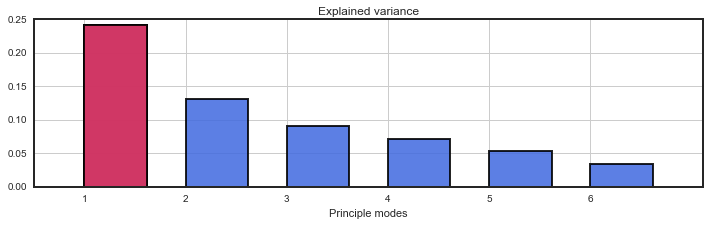

In [882]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 7.118)
ax.bar(np.arange(1, 7), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM)
ax.set_xticks(np.arange(1, 7))
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

**Spatial patterns**

In [883]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    #proj.drawparallels(np.arange(59, 100, 10), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color=[0.8, 0.8, 0.8], lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.PiYG, extend='both')
    #proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    return CS

In [884]:
clevs = np.array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])/5.0

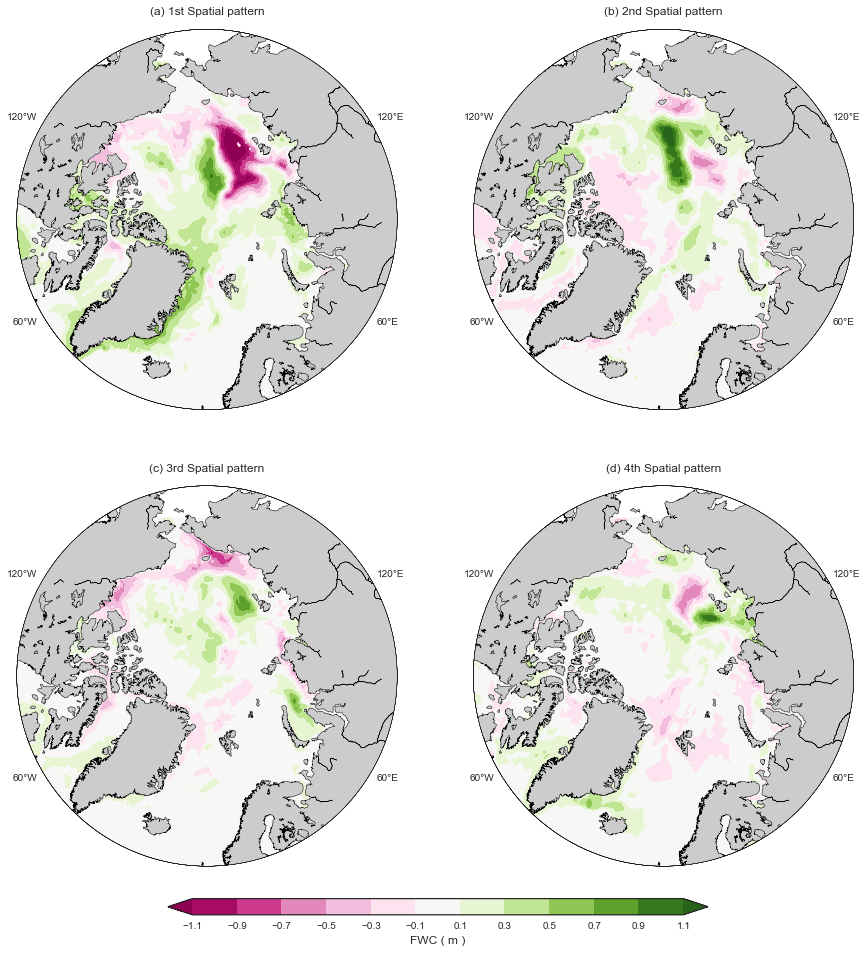

In [885]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
#colorbar
cax  = fig.add_axes([0.265, 0.08, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('FWC ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=0, direction='in')
CBar.set_ticks(clevs)

**Standardized timeseries**

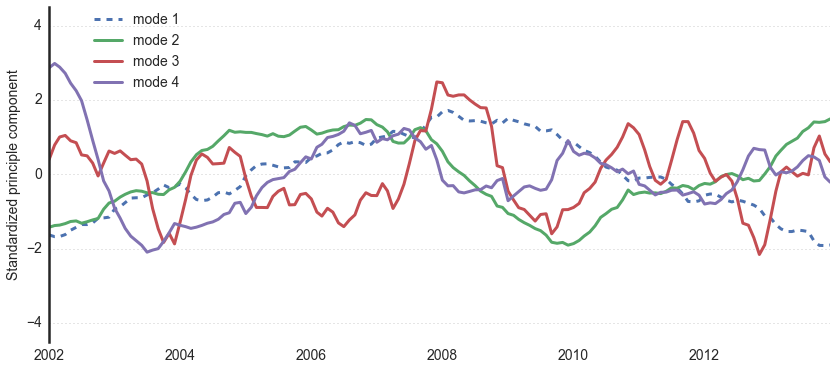

In [901]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-4.5, 4.5])
ax.set_ylabel('Standardized principle component', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0, :], '--',  lw=3, label='mode 1')
ax.plot(date_list, PC[1, :], '-', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
ax.plot(date_list, PC[3, :], '-', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

In [3]:
#fig = plt.figure(figsize=(14, 6))
#ax = fig.gca()
#ax.grid(linestyle=':')
#ax.yaxis.grid(False)
#ax.spines["top"].set_visible(False)
#ax.spines["bottom"].set_visible(False) 
#ax.spines["right"].set_visible(False)
#ax.set_xlim([date_list[0], date_list[143]])
#ax.set_ylim([-250, 250])
#ax.set_ylabel('Principle component with scale', fontsize=14)
#ax.xaxis.set_tick_params(labelsize=14)
#ax.yaxis.set_tick_params(labelsize=14)
#[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
#ax.tick_params(axis="both", which="both", bottom="off", top="off",    
#            labelbottom="on", left="off", right="off", labelleft="on")
#
#ax = fig.gca(); ax.grid()
#ax.plot(date_list, PC_with_scale[0, :], '--',  lw=3, label='mode 1')
#ax.plot(date_list, PC_with_scale[1, :], '-', lw=3, label='mode 2')
#ax.plot(date_list, PC_with_scale[2, :], '-',  lw=3, label='mode 3')
#ax.plot(date_list, PC_with_scale[3, :], '-', lw=3, label='mode 4')
#
#LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

## If I don't "dtrend" ?

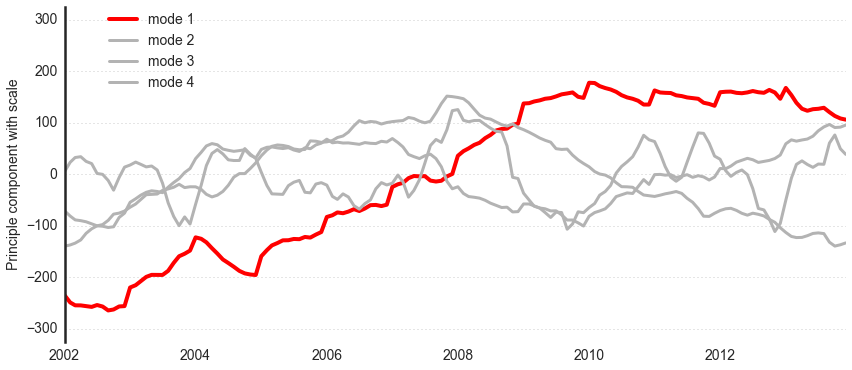

In [888]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-325, 325])
ax.set_ylabel('Principle component with scale', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC_wrong[0, :], '-',  lw=4, color='r', label='mode 1')
ax.plot(date_list, PC_wrong[1, :], '-', lw=3, color=[0.7, 0.7, 0.7], label='mode 2')
ax.plot(date_list, PC_wrong[2, :], '-',  lw=3, color=[0.7, 0.7, 0.7], label='mode 3')
ax.plot(date_list, PC_wrong[3, :], '-', lw=3, color=[0.7, 0.7, 0.7], label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

# Explainations of each mode

**Diagnose techniques**
+ Pearson correlation(`scipy.stats.stats.pearsonr`)
    - Significance can be estimated by Student's t-distribution test
+ Composit anomaly
    - $A_c = A(b>0)-A(b<0)$, here b is pc.

In [6]:
def Get_compsit_a(t, thres=2):
    thres = 1
    u_p    = np.nanmean(vozocrtx0[t>thres, :, :], 0)
    v_p    = np.nanmean(vomecrty0[t>thres, :, :], 0)
    u10_p  = np.nanmean(u10 [t>thres, :, :], 0)
    v10_p  = np.nanmean(v10 [t>thres, :, :], 0)
    Ba_p   = np.nanmean(Ba  [t>thres, :, :], 0)
    d18O_p = np.nanmean(d18O[t>thres, :, :], 0)
    FWC_p  = np.nanmean(FWC [t>thres, :, :], 0) 
    S_p    = np.nanmean(S   [t>thres, :, :], 0)
    T_p    = np.nanmean(T   [t>thres, :, :], 0)
    ssh_p  = np.nanmean(ssh [t>thres, :, :], 0)
    slp_p  = np.nanmean(slp [t>thres, :, :], 0)
    air_p  = np.nanmean(t2  [t>thres, :, :], 0)
    hgt1000_p = np.nanmean(hgt[t>thres, 0, :, :], 0)    
    hgt500_p  = np.nanmean(hgt[t>thres, 5, :, :], 0)

    u_n    = np.nanmean(vozocrtx0[t<-thres, :, :], 0)
    v_n    = np.nanmean(vomecrty0[t<-thres, :, :], 0)
    u10_n  = np.nanmean(u10 [t<-thres, :, :], 0)
    v10_n  = np.nanmean(v10 [t<-thres, :, :], 0)
    Ba_n   = np.nanmean(Ba  [t<-thres, :, :], 0)
    d18O_n = np.nanmean(d18O[t<-thres, :, :], 0)
    FWC_n  = np.nanmean(FWC [t<-thres, :, :], 0)
    T_n    = np.nanmean(T   [t<-thres, :, :], 0)
    ssh_n  = np.nanmean(ssh [t<-thres, :, :], 0)
    slp_n  = np.nanmean(slp [t<-thres, :, :], 0)
    air_n  = np.nanmean(t2  [t<-thres, :, :], 0)
    hgt1000_n = np.nanmean(hgt[t<-thres, 0, :, :], 0)
    hgt500_n  = np.nanmean(hgt[t<-thres, 5, :, :], 0)

    u = u_p - u_n; v = v_p - v_n; dsst = T_p - T_n; dssh = ssh_p - ssh_n
    dslp = slp_p - slp_n; dair = air_p - air_n; atmos_u10 = u10_p - u10_n; atmos_v10 = v10_p - v10_n
    dFWC = FWC_p - FWC_n; dBa = Ba_p - Ba_n; dd18O = d18O_p - d18O_n
    dhgt1000 = hgt1000_p - hgt1000_n; dhgt500 = hgt500_p - hgt500_n
    return u, v, atmos_u10, atmos_v10, dFWC, dBa, dd18O, dssh, dslp, dair, dT, dhgt1000, dhgt500, S_p

In [403]:
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])
lev_slp = np.array([-3.85, -3.15, -2.45, -1.75, -1.05, -0.35, 0.35, 1.05, 1.75, 2.45, 3.15, 3.85])
lev_corr = np.array([-0.45, -0.35, -0.25, -0.15, -0.1, 0.1, 0.15, 0.25, 0.35, 0.45])

In [5]:
def plotyy(x, y1, y2):
    fig = plt.figure(figsize=(14, 4))
    ax = fig.gca(); ax.grid()
    ax2 = ax.twinx()

    ax.grid(linestyle=':')
    ax.grid(False)
    #ax.set_ylim([-2.5, 2.5])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False) 
    #ax.set_xlim([date_list[0], date_list[143]])
    #ax.set_ylabel('Standardized PC of EOF mode 1', fontsize=14, color='r')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
    ax.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")
    for tl in ax.get_yticklabels():
        tl.set_color('r')

    #ax2.set_ylim([0.015, 0.055])
    #ax2.set_yticks(np.arange(0.02, 0.05, 0.005))
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.yaxis.set_tick_params(labelsize=14)
    #ax2.set_ylabel('Intensity of transpolar drift', fontsize=14, color='b')
    for tl in ax2.get_yticklabels():
        tl.set_color('b')
    
    ax.plot(x, y1, 'r', lw=3)
    #for i in range(12, 144, 12):
    #    ax.axvline(date_list[i], ymin=0.1, ymax=0.9, color='k', lw=1, ls=':')
    ax2.plot(x, y2, 'b', lw=3)
    return ax, ax2

def draw_SLP_AT():
    n = 6
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    
    proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)

    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(slp_lon, slp_lat)
    CS = proj.contourf(x, y, dslp, lev_slp, cmap = plt.cm.RdBu_r, extend='both')
    
    #Q = proj.quiver(x[::n, ::n], y[::n, ::n], atmos_u10[::n, ::n], atmos_v10[::n, ::n], 
    #width=0.002, headwidth=3, scale=50, color='0.25')
    #qk = plt.quiverkey(Q, 0.2, 0.15, 1, r'$1\ m\cdot s^{-1}$', coordinates='figure', fontproperties={'weight': 'bold'})
    
    cax  = fig.add_axes([0.105, 0.3, 0.4, 0.02])
    #cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('SLP ( hPa )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_slp)
    
    ax1.set_title('(a) SLP, 10m wind', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(slp_lon, slp_lat)
    
    CS = proj.contourf(x, y, dair, lev_dT/2.0, cmap = plt.cm.RdBu_r, extend='both')
 
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Air Temp. ( deg C )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/2.0)
    
    ax2.set_title('(b) 2m Air Temp.', fontsize=14)
    
def draw_SSH_UV():
    n=4
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
        
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    
    CS = proj.contourf(x, y, dssh*100, lev_dT, cmap = plt.cm.RdBu_r, extend='both')

    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('SSH  ( 0.01m )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT)
    
    ax1.set_title('(a) SSH', fontsize=14)
    
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], 
    width=0.002, headwidth=3, scale=1.75, color='0.25')
    qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$', coordinates='figure', fontproperties={'weight': 'bold'})
    
    ax2.set_title('(b) Ocean flow', fontsize=14)

def draw_FWC():
    fig=plt.figure(figsize=(8, 8));
    ax1 = fig.gca()
    
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dFWC, lev_dT/4.0, cmap = plt.cm.PiYG, extend='both', )   
    proj.contourf(x, y, S_p, [34.8, 40], hatches=['\\', ' '], colors='none', zorder=4)
    proj.contour(x, y, S_p, [34.8], linewidths=2.5, colors=('k',), zorder=4)
    
    cax  = fig.add_axes([0.1375, 0.05, 0.75, 0.035])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Freshwater content (dep < 65m)  ( m )', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/4.0)
    
    ax1.set_title('(a) Freshwater content', fontsize=14)
    
def draw_Ba_d18O():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dBa, lev_dT, cmap = plt.cm.BrBG, extend='both')
    
    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Dissolved Barium (nm)', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT)

    ax1.set_title('(b.1) Dissolved Ba', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(nav_lon, nav_lat)
    CS = proj.contourf(x, y, dd18O, lev_dT/5.0, cmap = plt.cm.RdBu_r, extend='both')
    
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('d18O', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_dT/5.0)

    ax2.set_title('(b.2) d18O', fontsize=14)
    
def draw_slp_corr():
    fig=plt.figure(figsize=(8, 8));
    ax1 = fig.gca()

    proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None, zorder=0)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(slp_lon, slp_lat)
    CS = proj.contourf(x, y, corr_slp, lev_corr, cmap = plt.cm.RdBu_r, extend='both')
    proj.contourf(x, y, p_slp, [0, 0.05], hatches=['...', ' '], colors='none', zorder=4)
    
    cax  = fig.add_axes([0.1375, 0.05, 0.75, 0.035])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Correlation ind.', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_corr)
    return ax1

def draw_500_1000_corr():
    fig=plt.figure(figsize=(16, 16));

    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=0, round=True, ax=ax1)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color='0.8', lake_color=None, zorder=0)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(hgt_lon, hgt_lat)
    CS = proj.contourf(x, y, corr1000, lev_corr, cmap = plt.cm.RdBu_r, extend='both')
    proj.contourf(x, y, p1000, [0, 0.05], hatches=['...', ' '], colors='none', zorder=4)
    proj.contour(x, y, corr1000, [-0.1, 0.1], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.175, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Correlation ind.', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_corr)

    #ax1.set_title('(c.1) PC .v.s. 1000hPa GPH', fontsize=14)

    proj=Basemap(projection='npstere', resolution='l', boundinglat=45, lon_0=0, round=True, ax=ax2)
    proj.drawmeridians(np.array([60, 120, 240, 300]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    #proj.fillcontinents(color='0.8', lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(hgt_lon, hgt_lat)
    CS = proj.contourf(x, y, corr500, lev_corr, cmap = plt.cm.RdBu_r, extend='both')
    proj.contourf(x, y, p500, [0, 0.05], hatches=['...', ' '], colors='none', zorder=4)
    proj.contour(x, y, corr500, [-0.1, 0.1], linewidths=2.5, colors=('gray',), zorder=4)
    
    cax  = fig.add_axes([0.6, 0.3, 0.25, 0.02])
    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
    CBar.set_label('Correlation ind.', fontsize=12)
    CBar.ax.tick_params(axis='x', length=0, direction='in')
    CBar.set_ticks(lev_corr)

    #ax2.set_title('(c.2) PC v.s. 500hPa GPH', fontsize=14)
    return ax1, ax2

In [455]:
### Assumptions
#* EOF(FWC) has been done with "dtrend" and "anomaly" data, so no information about sea-ice varibility/trend & seasonality of river input.
#* No EU runoff in CAA;
#* Assume that convection is not important;
#* NA, EU Runoff: high Ba, low d18O, high FWC;
#* Some CAA Runoff: low Ba, low d18O, high FWC;
#* Atlantic inflow: low Ba, high d18O, low FWC (high Salin.);
#* Pacific inflow: low Ba, low d18O (comparing with Atlantic), high FWC.

## First mode: Dipole Anomaly

* Very good positive (0.67, 0.01) with the Transpolar Drift Stream (TDS) intensity.
* Good positive (0.27, 0.01) with SSH at Beaufort Gyre.
* Not related (-0.04, -) with Arctic Oscillation (both NOAA and ANHA4).

In [40]:
#pearsonr(PC[0, :], vdt)
#pearsonr(PC[0, :], SSH_BG)
#pearsonr(PC[0, :], AO_NOAA)

(0.66550203718142587, 9.1161257090469969e-20)

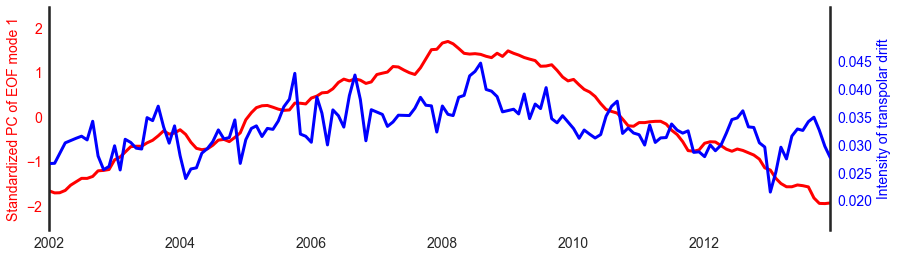

In [914]:
ax, ax2 = plotyy(date_list, PC[0, :], vdt)

ax.set_ylim([-2.5, 2.5])
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 1', fontsize=14, color='r')
ax2.set_ylim([0.015, 0.055])
ax2.set_yticks(np.arange(0.02, 0.05, 0.005))
ax2.set_ylabel('Intensity of transpolar drift', fontsize=14, color='b')

### Q1: What controls mode 1 ?

In [1021]:
u, v, atmos_u10, atmos_v10, dFWC, dBa, dd18O, dssh, dslp, dair, dT, dhgt1000, dhgt500, S_p = Get_compsit_a(PC[0, :])

**Correlation between the Transpolar Drift Stream (TDS) intensity and GPH.**

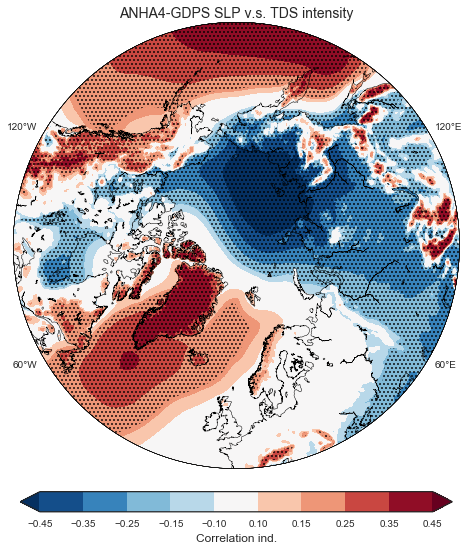

In [971]:
corr_slp = np.zeros([233, 801])
p_slp = np.zeros([233, 801])
for i in range(233):
    for j in range(801):
        corr_slp[i, j], p_slp[i, j] = pearsonr(vdt, slp[:, i, j])
ax = draw_slp_corr()
ax.set_title('ANHA4-GDPS SLP v.s. TDS intensity', fontsize=14)

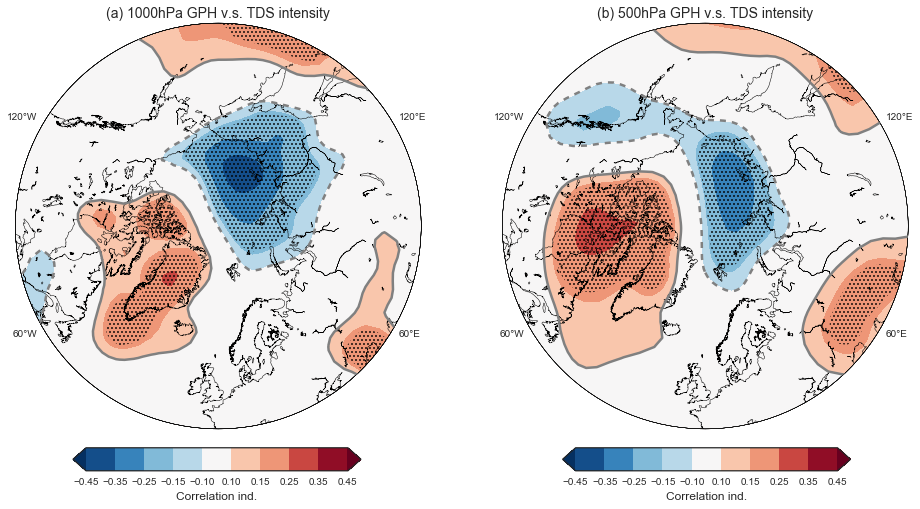

In [967]:
corr1000 = np.zeros([73, 145])
corr500  = np.zeros([73, 145])
p1000    = np.zeros([73, 145])
p500     = np.zeros([73, 145])
for i in range(73):
    for j in range(145):
        hgt1000_temp = hgt1000_a[:, i, j]
        hgt500_temp = hgt500_a[:, i, j]
        corr1000[i, j], p1000[i, j] = pearsonr(vdt, hgt1000_temp)
        corr500[i, j], p500[i, j] = pearsonr(vdt, hgt500_temp)
ax1, ax2 = draw_500_1000_corr()
ax1.set_title('(a) 1000hPa GPH v.s. TDS intensity', fontsize=14)
ax2.set_title('(b) 500hPa GPH v.s. TDS intensity', fontsize=14)

**The composite anomaly of ANHA4-GDPS SLP (a) and 2m Air Temp. (b)**

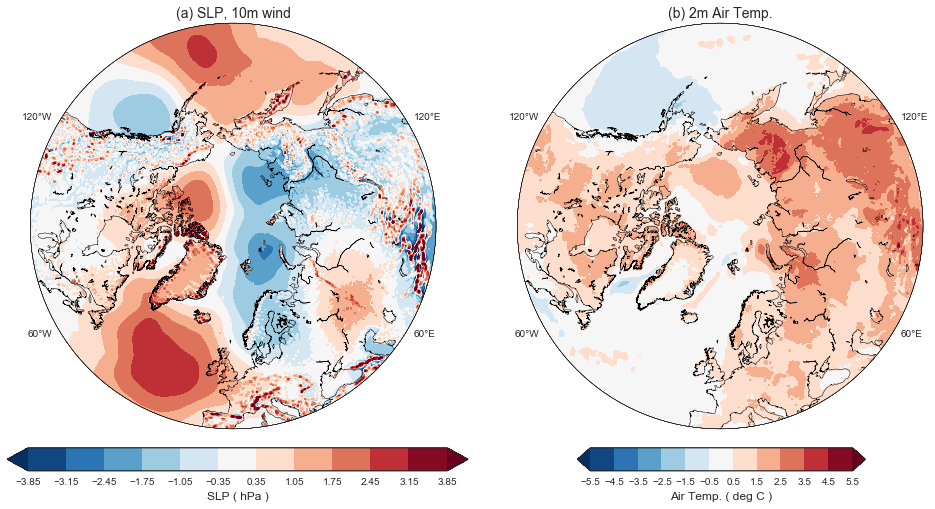

In [1028]:
draw_SLP_AT()

** Mode 1 is under the impact of Arctic atmospheric Dipole Anomaly (DA)**

**What is DA**
+ **DA** played an important role in the summer 2007 sea-ice minimum.
+ Defined as the second mode of 20N-90N monthly mean SLP EOF
    - Wu et al. (2006)
>   <img src="../../_figures/DA_Wu2006.PNG" width=250 align="left"/>


**Why DA plays important role in mode 1**
+ The SLP composite anomaly shows a **DA**-like pattern.
+ Mode 1 has good correlation with TDS intensity, The correlation between TDS intensity and SLP/GPH show a **DA**-like pattern.
    - According to Wang et al. (2009): 
    >During a positive phase of the DA (i.e., the SLP has a positive anomaly in the Canadian Archipelago and negative one in the Barents Sea), the anomalous meridional wind blows from the western to the eastern Arctic, favorable to the Trans-polar Drift Stream (TDS) that flushes sea ice out of the Arctic into the Barents and Greenland seas. [Wu et al., 2006; Watanabe et al., 2006]  
+ Both mode 1 and **DA** are significant from 2007-2008 (Wang et al., 2009).

[1] *Wu et al. (2006), Dipole Anomaly in the winter Arctic atmosphere and its association with Arctic sea ice motion. J. Climate, **19**.*

[2] *Watanabe et al. (2006), Arctic dipole anomaly and its contribution to sea ice export from the Arctic Ocean in the 20th century, Geophys. Res. Lett., **33**(L23703).*

[3] *Wang et al. (2009), Is the Dipole Anomaly a major driver to record lows in Arctic summer sea ice extent?. Geophys. Res. Lett. **36**(5) .*

### Q2: How *DA* affects the surface ocean ?

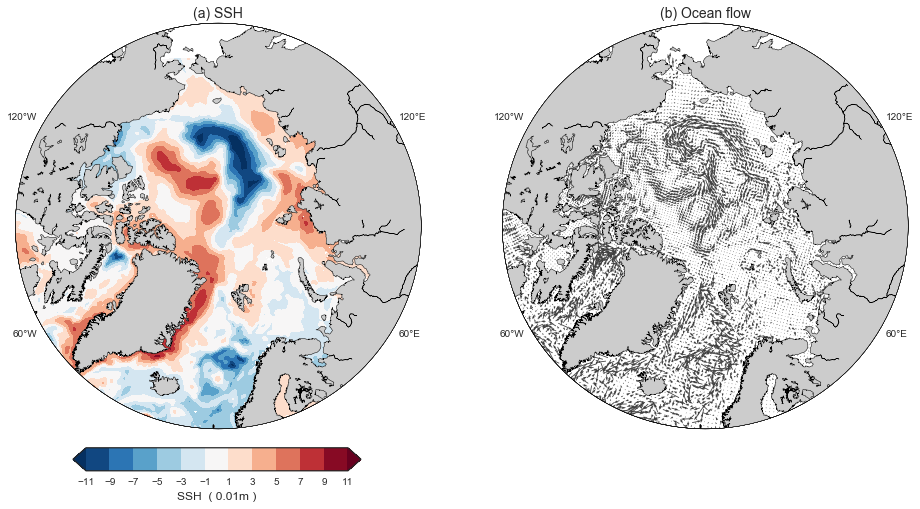

In [919]:
draw_SSH_UV()

Under the control of **DA**, the surface ocean shows the following change:
* Very strong TDS
* Stronger "conveyor belt" from Laptev Sea to Central Arctic and Beaufort Gyre.
* Stronger off shore current at Beaufort Sea continental shelf.
* Strong Beaufort Gyre.
* Anti-cyclonic flow anomaly at CAA, weaker BG-Baffin Bay flow.
* Stronger eastward flow at EU continental shelf.
* Less Pacific inflow


For sea-ice:
* **DA** enhances south wind, makes air temp. higher, more Sea-ice melt at central Arctic and Kara Sea
* No significant SST change, can only be found in air temp. 

### Q3: How will different freshwater components (EU runoff, NA runoff, Sea-ice melt) respond to *DA*

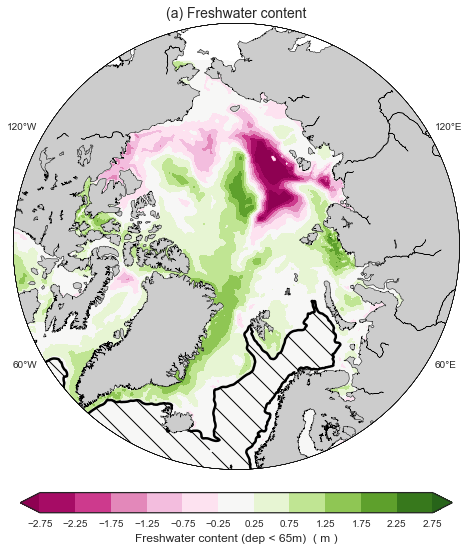

In [1010]:
draw_FWC()

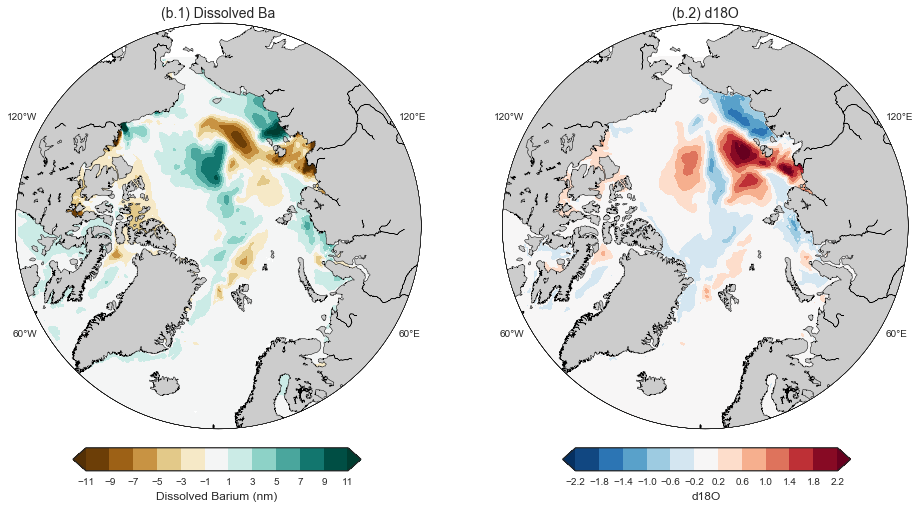

In [1011]:
draw_Ba_d18O()

Under the control of **DA**:
* More EU runoff goes to TDS and BG
* More NA runoff goes to TDS and BG
* Less NA runoff goes to CAA, but CAA runoff accumulates locally, FWC balanced.
* More runoff/Ek transport in East Siberian Sea, but less Pacific inflow, FWC balanced.
* More sea-ice melt water in Central Arctic, Kara Sea. 
* In total, more liquid FW goes to North Atlantic under positive **DA** phase

## Second mode: interannual AO signal

In [1012]:
u, v, atmos_u10, atmos_v10, dFWC, dBa, dd18O, dssh, dslp, dair, dT, dhgt1000, dhgt500, S_p = Get_compsit_a(PC[1, :])

### Q1: What controls mode 2 ?

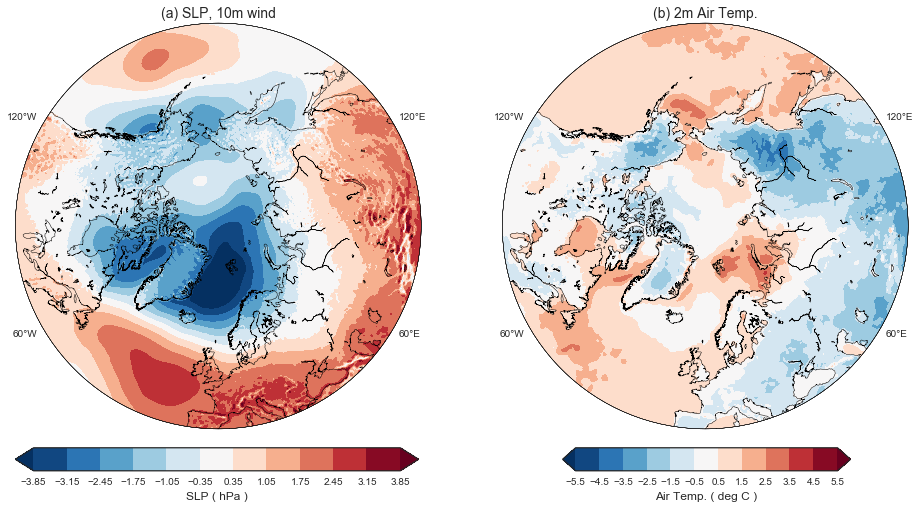

In [1014]:
draw_SLP_AT()

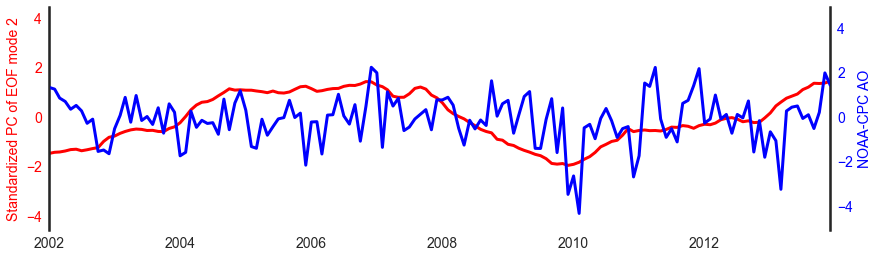

In [926]:
ax, ax2 = plotyy(date_list, PC[1, :], AO_NOAA)

ax.set_ylim([-4.5, 4.5])
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 2', fontsize=14, color='r')
ax2.set_ylim([-5, 5])
#ax2.set_yticks(np.arange(0.025, 0.275, 0.05))
ax2.set_ylabel('NOAA-CPC AO', fontsize=14, color='b')

Mode 2 is under the impact of the **Arctic Oscillation (AO)** because:
* ANHA4-GDPS SLP composite anomaly shows a AO-like pattern.
* AO is an important atmospheric driver of surface Arctic Ocean, it should be in the result.

*By looking at AO index and PC2, mode 2 has a good response with AO's interannual variability (4-6 yr cycle).*

### Q2: How AO affects surface ocean

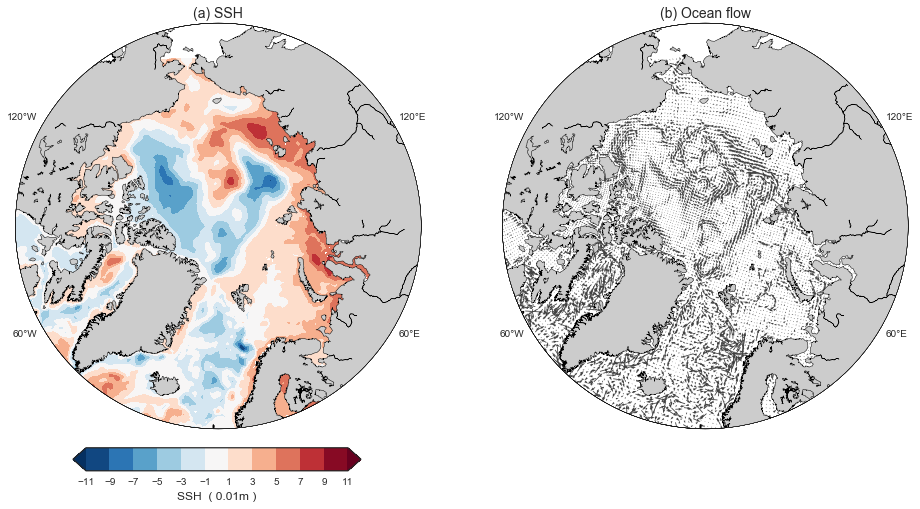

In [927]:
draw_SSH_UV()

Under the control of **AO**, the surface ocean shows the following change:
* Anomalous cyclonic flow in the central Arctic ocean.
* Weaker Beaufort Gyre.
* Stronger BG-Baffin Bay flow
* Anomalous anti-cyclonic flow in Chukchi Sea
* Higher sea surface on EU continental shelf

### Q3: How will different freshwater components respond to *AO*

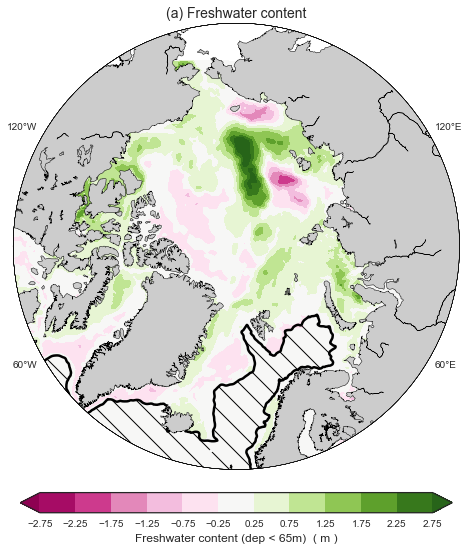

In [1015]:
draw_FWC()

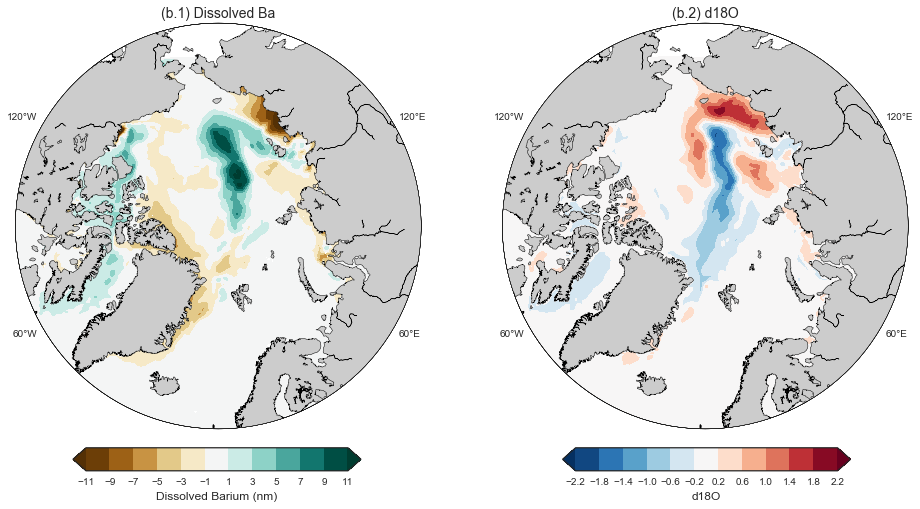

In [929]:
draw_Ba_d18O()

Under the control of **DA**:
* More NA runoff goes to CAA (instead of BG)
* **Laptev Sea, East Siberian Sea runoff accumulates in Chukchi Sea, partially being transported to Canada Basin.**
* More EU runoff but less NA runoff goes to Fram Strait
* More Sea-ice melt in Kara Sea <-- need more evidence 

The bold one consistant with *Morison et al. (2012).*, therefore another reason that mode 2 is AO.

<img src="../../_figures/Morson_fig4.PNG" width=750 align="left"/>

*Morison et al. (2012) Changing arctic ocean freshwater pathways. Nature **481**.7379, 66-70.*

## Third Mode: Synoptic scale Beaufort Sea High

* **Very good positive** (0.56, 0.01) with Beaufort Gyre SSH

In [955]:
#pearsonr(PC[2, :], SSH_BG)

(0.56431287570252975, 1.7605960940677861e-13)

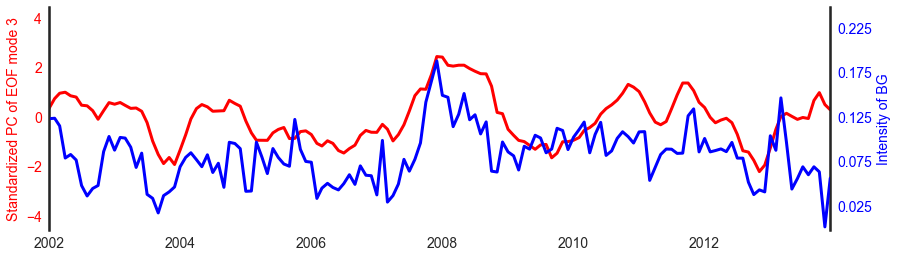

In [904]:
ax, ax2 = plotyy(date_list, PC[2, :], SSH_BG)

ax.set_ylim([-4.5, 4.5])
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 3', fontsize=14, color='r')
ax2.set_ylim([0, 0.25])
ax2.set_yticks(np.arange(0.025, 0.275, 0.05))
ax2.set_ylabel('Intensity of BG', fontsize=14, color='b')

### Q1: What controls mode 3 ?

In [1017]:
u, v, atmos_u10, atmos_v10, dFWC, dBa, dd18O, dssh, dslp, dair, dT, dhgt1000, dhgt500, S_p = Get_compsit_a(PC[2, :])

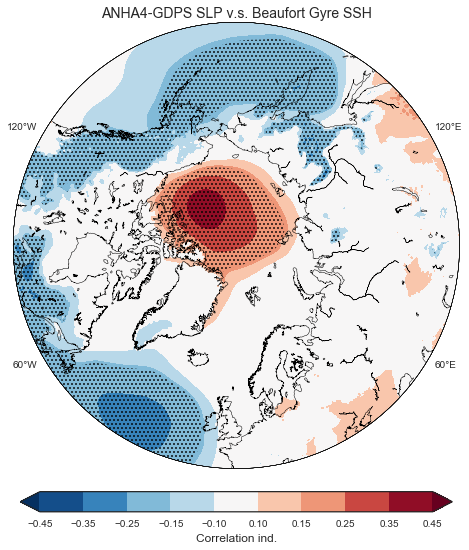

In [972]:
corr_slp = np.zeros([233, 801])
p_slp = np.zeros([233, 801])
for i in range(233):
    for j in range(801):
        corr_slp[i, j], p_slp[i, j] = pearsonr(SSH_BG, slp[:, i, j])
ax = draw_slp_corr()
ax.set_title('ANHA4-GDPS SLP v.s. Beaufort Gyre SSH', fontsize=14)

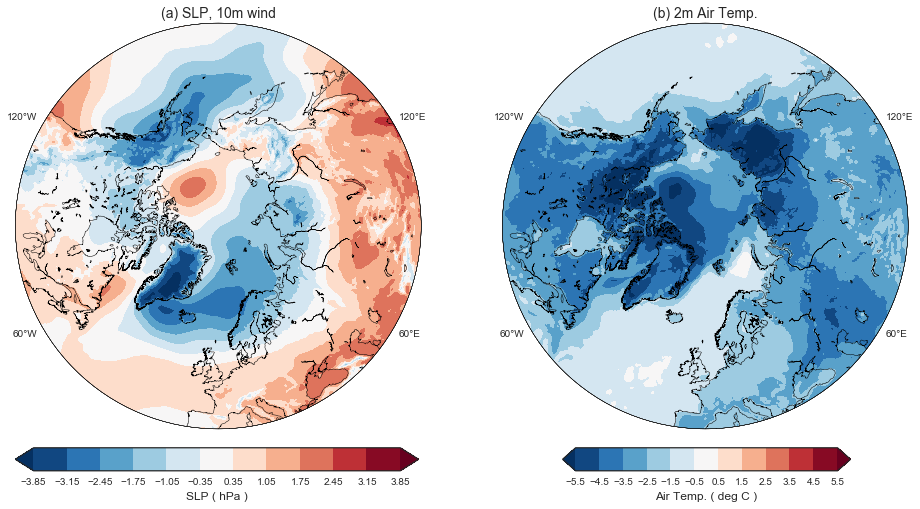

In [1018]:
draw_SLP_AT()

Mode 3 is characterized by a **strong Beaufort Sea High (BSH)** as indicated by slp composite anomaly.

According to *Serreze and Barrett (2011)* strong BSH could be caused by:
* negative AO <--- the reverse of mode2
* negative NAO
* positive DA <--- mode1
* positive PNA

So mode 3 is a mix of many different atmospheric factors/teleconnection patterns. And **on the synoptic scale, a strong BSH**.

Serreze, M. C., and A. P. Barrett. (2011) Characteristics of the Beaufort Sea high. J. Climate **24**.1: 159-182.

### Q2: How a strong BSH affects surface ocean

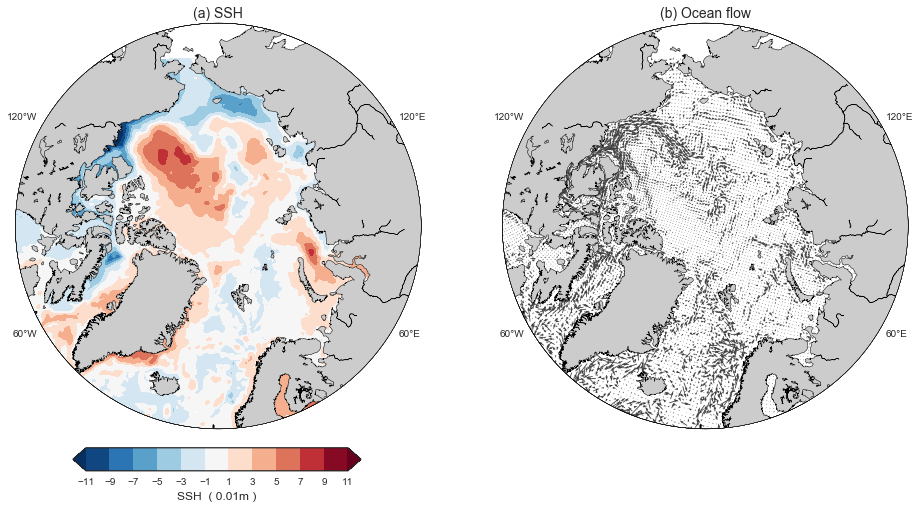

In [932]:
draw_SSH_UV()

### Q3: How will different freshwater components respond to a strong BSH

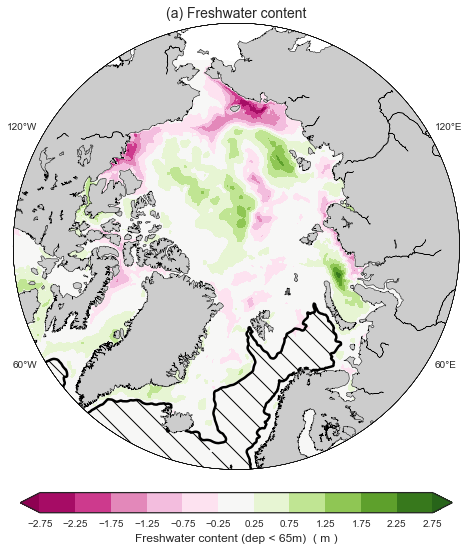

In [1019]:
draw_FWC()

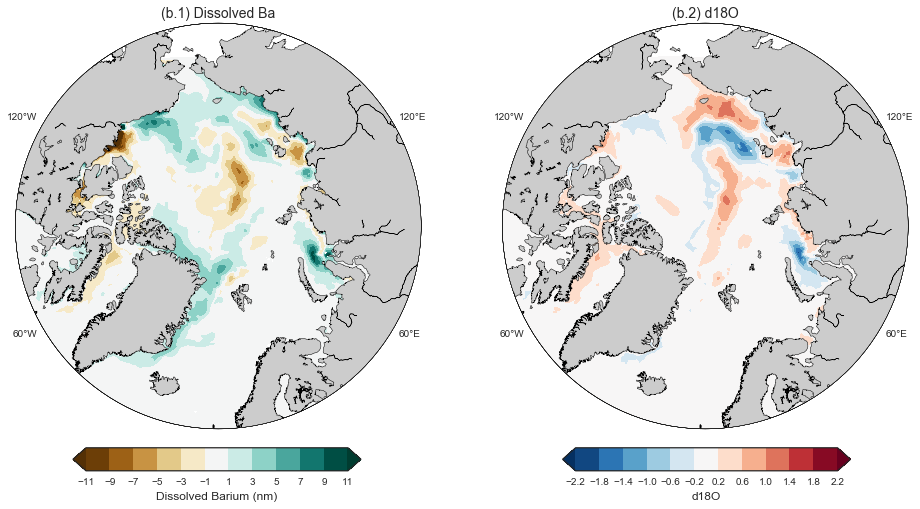

In [934]:
draw_Ba_d18O()

* More NA runoff goes to BG and Fram Strait (instead of CAA)
* Laptev Sea & East Siberian Sea runoff accumulates beside East Siberian Island and the northern extend of BG
* Kara Sea runoff accumulate locally
* Less Pacific inflow

* Less Sea-ice melt in many regions <--- need more evidence

Complete the "case study" of 2008 high BG, how mode1 and mode3 play their role. 